# 1D RESOLVE and SkyTEM Bookpurnong Inversion with SimPEG

In this notebook, we run a 1D inversion of electromagnetic data collected over the BOokpurnong Irrigation District in Australia. We use SimPEG for SkyTEM forward simulation and use CoFI to solve the inverse problem.

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/simpeg_skytem/simpeg_skytem.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example: [Heagy et al., 2017 1D RESOLVE and SkyTEM Bookpurnong Inversions](https://docs.simpeg.xyz/content/examples/20-published/plot_booky_1D_time_freq_inv.html)

The RESOLVE data are inverted first. This recovered model is then used as a reference model for the SkyTEM inversion.

## 0. Import modules and environment preparation

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

#TODO install simpeg (test with pip first)

In [2]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/simpeg-research/bookpurnong-inversion.git

We will need the following packages:

- `numpy` for matrices and matrix-related operations
- `scipy` for scientific constants
- `matplotlib` for plotting
- `h5py` for loading dataset
- `simpeg` and `descritize` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [3]:
import os
import h5py

import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt

import SimPEG
from SimPEG.electromagnetics import frequency_domain as FDEM, time_domain as TDEM
import discretize

import cofi

## 1. Load data and plotting

### 1.1 Load the dataset

In [4]:
resolve = h5py.File("bookpurnong-inversion/bookpurnong-data/booky_resolve.hdf5", "r")
skytem = h5py.File("bookpurnong-inversion/bookpurnong-data/booky_skytem.hdf5", "r")
river_path = resolve["river_path"][()]

### 1.2 Define sounding location

In [5]:
# choose a sounding location to invert
xloc, yloc = 462100.0, 6196500.0
rxind_skytem = np.argmin(
    abs(skytem["xy"][:, 0] - xloc) + abs(skytem["xy"][:, 1] - yloc)
)
rxind_resolve = np.argmin(
    abs(resolve["xy"][:, 0] - xloc) + abs(resolve["xy"][:, 1] - yloc)
)

### 1.3 Plot RESOLVE and SkyTEM data on 2D plane

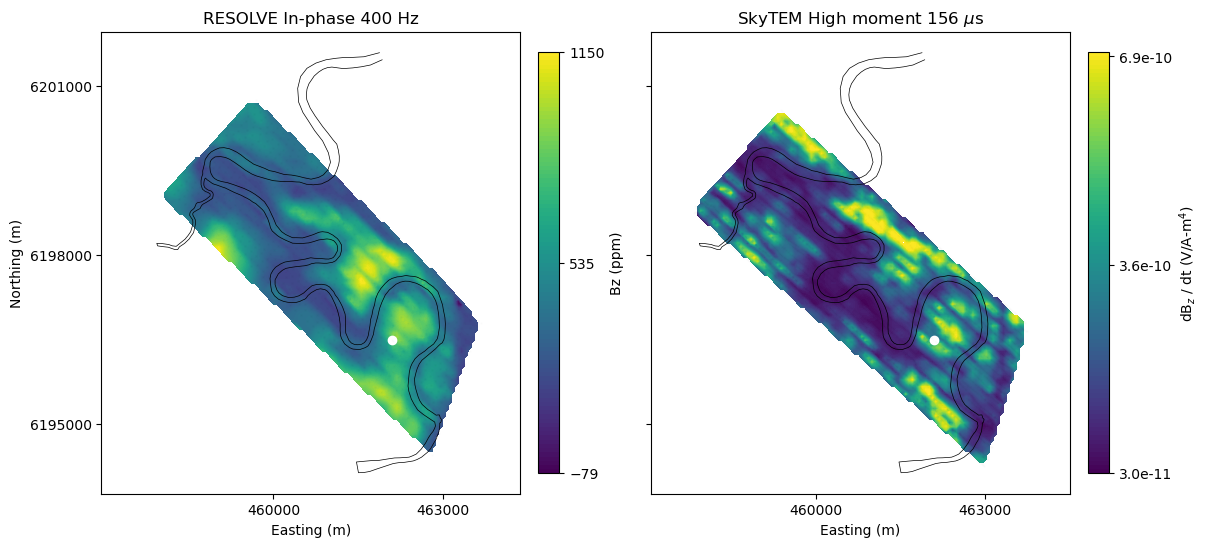

In [6]:
fig = plt.figure(figsize=(13, 6))
title = ["RESOLVE In-phase 400 Hz", r"SkyTEM High moment 156 $\mu$s"]
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
axs = [ax1, ax2]
out_re = SimPEG.utils.plot2Ddata(
    resolve["xy"],
    resolve["data"][:, 0],
    ncontour=100,
    contourOpts={"cmap": "viridis"},
    ax=ax1,
)
vmin, vmax = out_re[0].get_clim()
cb_re = plt.colorbar(
    out_re[0], ticks=np.linspace(vmin, vmax, 3), ax=ax1, fraction=0.046, pad=0.04
)
temp_skytem = skytem["data"][:, 5].copy()
temp_skytem[skytem["data"][:, 5] > 7e-10] = 7e-10
out_sky = SimPEG.utils.plot2Ddata(
    skytem["xy"][:, :2],
    temp_skytem,
    ncontour=100,
    contourOpts={"cmap": "viridis", "vmax": 7e-10},
    ax=ax2,
)
vmin, vmax = out_sky[0].get_clim()
cb_sky = plt.colorbar(
    out_sky[0],
    ticks=np.linspace(vmin, vmax * 0.99, 3),
    ax=ax2,
    format="%.1e",
    fraction=0.046,
    pad=0.04,
)
cb_re.set_label("Bz (ppm)")
cb_sky.set_label("dB$_z$ / dt (V/A-m$^4$)")

for i, ax in enumerate(axs):
    xticks = [460000, 463000]
    yticks = [6195000, 6198000, 6201000]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.plot(xloc, yloc, "wo")
    ax.plot(river_path[:, 0], river_path[:, 1], "k", lw=0.5)

    ax.set_aspect("equal")
    if i == 1:
        ax.plot(skytem["xy"][:, 0], skytem["xy"][:, 1], "k.", alpha=0.02, ms=1)
        ax.set_yticklabels([str(" ") for f in yticks])
    else:
        ax.plot(resolve["xy"][:, 0], resolve["xy"][:, 1], "k.", alpha=0.02, ms=1)
        ax.set_yticklabels([str(f) for f in yticks])
        ax.set_ylabel("Northing (m)")
    ax.set_xlabel("Easting (m)")
    ax.set_title(title[i])
    ax.axis("equal")
# plt.tight_layout()

## 2. Initial setup

### 2.1 Set 2D cylindrical mesh

In [7]:
cs, ncx, npad = 1.0, 10.0, 20
hx = [(cs, ncx), (cs, npad, 1.3)]
npad = 12
temp = np.logspace(np.log10(1.0), np.log10(12.0), 19)
temp_pad = temp[-1] * 1.3 ** np.arange(npad)
hz = np.r_[temp_pad[::-1], temp[::-1], temp, temp_pad]
mesh = discretize.CylindricalMesh([hx, 1, hz], "00C")
active = mesh.cell_centers_z < 0.0

### 2.2 Set a SurjectVertical1D mapping

Note: this sets our inversion model as 1D log conductivity below subsurface

In [8]:
active = mesh.cell_centers_z < 0.0
actMap = SimPEG.maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.shape_cells[2])
mapping = SimPEG.maps.ExpMap(mesh) * SimPEG.maps.SurjectVertical1D(mesh) * actMap
sig_half = 1e-1
sig_air = 1e-8
sigma = np.ones(mesh.shape_cells[2]) * sig_air
sigma[active] = sig_half

### 2.3 Define initial reference model

In [9]:
m0 = np.log(sigma[active])

## 3. RESOLVE inversion

### 3.1 Define forward simulation

In [10]:
# Bird height from the surface
b_height_resolve = resolve["src_elevation"][()]
src_height_resolve = b_height_resolve[rxind_resolve]

In [11]:
# Set Rx (In-phase and Quadrature)
rxOffset = 7.86

bzr = FDEM.Rx.PointMagneticFluxDensitySecondary(
    np.array([[rxOffset, 0.0, src_height_resolve]]),
    orientation="z",
    component="real",
)

bzi = FDEM.Rx.PointMagneticFluxDensity(
    np.array([[rxOffset, 0.0, src_height_resolve]]),
    orientation="z",
    component="imag",
)

In [12]:
# Set Source (In-phase and Quadrature)
frequency_cp = resolve["frequency_cp"][()]
freqs = frequency_cp.copy()
srcLoc = np.array([0.0, 0.0, src_height_resolve])
source_list = [
    FDEM.Src.MagDipole([bzr, bzi], freq, srcLoc, orientation="Z") for freq in freqs
]

In [13]:
# Set FDEM survey (In-phase and Quadrature)
survey = FDEM.Survey(source_list)
prb = FDEM.Simulation3DMagneticFluxDensity(mesh, sigmaMap=mapping, solver=SimPEG.Solver)
prb.survey = survey

### 3.2 Define objective function

tmp notes: http://docs.simpeg.xyz/content/api/SimPEG.regularization.html

In [33]:
# Primary field
bp = -scipy.constants.mu_0 / (4 * np.pi * rxOffset**3)

# Observed data
cpi_inds = [0, 2, 6, 8, 10]
cpq_inds = [1, 3, 7, 9, 11]
dobs_re = (
    np.c_[
        resolve["data"][rxind_resolve, :][cpi_inds],
        resolve["data"][rxind_resolve, :][cpq_inds],
    ].flatten()
    * bp
    * 1e-6
)

# Uncertainty
relative = np.repeat(np.r_[np.ones(3) * 0.1, np.ones(2) * 0.15], 2)
floor = 20 * abs(bp) * 1e-6
std = abs(dobs_re) * relative + floor

# Data Misfit
data_resolve = SimPEG.data.Data(dobs=dobs_re, survey=survey, standard_deviation=std)
dmisfit = SimPEG.data_misfit.L2DataMisfit(simulation=prb, data=data_resolve)

# Regularization
reg_lamda_damping = 0.05
reg_lamda_flattening = 0.05
reg_lamda_smoothing = 0.1
reg_damping = cofi.utils.QuadraticReg("damping", (m0.size,), m0.copy())
reg_flattening = cofi.utils.QuadraticReg("flattening", (m0.size,), m0.copy())
reg_smoothing = cofi.utils.QuadraticReg("smoothing", (m0.size,), m0.copy())
reg = reg_lamda_damping * reg_damping + \
        reg_lamda_flattening * reg_flattening + \
        reg_lamda_smoothing * reg_smoothing

In [34]:
def my_objective(model):
    return dmisfit(model) + reg(model)

def my_gradient(model):
    # return dmisfit.deriv(model) + reg.deriv(model)
    return dmisfit.deriv(model) + reg.gradient(model)

### 3.3 Run inversion with CoFI

In [35]:
problem_resolve = cofi.BaseProblem()
problem_resolve.set_objective(my_objective)
problem_resolve.set_gradient(my_gradient)
problem_resolve.set_initial_model(m0)

In [36]:
options_resolve = cofi.InversionOptions()
options_resolve.set_tool("scipy.optimize.minimize")
options_resolve.set_params(method="L-BFGS-B")

In [37]:
inversion_resolve = cofi.Inversion(problem_resolve, options_resolve)
res_resolve = inversion_resolve.run()

### SolverWarning ###: Accuracy on solve is above tolerance: 3.111759e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 2.726818e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 2.753226e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.753226e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.141415e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.141415e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.750859e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.750859e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.644611e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.644611e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.032153e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.032153e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.096444e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.096444e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.661748e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.661748e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.335434e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.335434e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.171975e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 1.045853e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.171975e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)
/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 1.045853e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.173055e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.173055e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.975826e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.975826e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.538389e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.538389e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.430894e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.430894e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.714171e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.714171e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.575541e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.575541e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.028292e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.028292e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.016346e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.016346e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.302942e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.302942e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.656341e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.656341e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.082765e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.082765e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.819650e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.819650e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 1.816124e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 1.816124e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.265520e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.265520e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.635992e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.635992e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.511758e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.511758e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.757684e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.757684e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.937535e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.937535e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.737931e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.737931e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.909133e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.909133e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 4.217514e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 4.217514e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.199865e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.199865e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.435517e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.435517e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.377453e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.377453e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.150114e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.150114e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.211252e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.211252e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.549079e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.549079e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.731059e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.731059e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.410915e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.410915e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.316962e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.316962e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.777914e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.777914e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.344405e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.344405e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.794137e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.794137e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 1.674369e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 1.674369e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.503434e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.503434e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.503434e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 5.030544e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 5.030544e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 4.114144e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 4.114144e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 4.114144e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 3.200286e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.200286e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 2.085509e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 2.085509e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 4.120401e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 4.120401e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.412405e-06 > 1.000000e-06


/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.9/site-packages/SimPEG/utils/solver_utils.py:18: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 3.412405e-06 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


### SolverWarning ###: Accuracy on solve is above tolerance: 3.412405e-06 > 1.000000e-06
### SolverWarning ###: Accuracy on solve is above tolerance: 3.412405e-06 > 1.000000e-06


### 3.4 Plot RESOLVE inversion results

In [38]:
dpred_re = prb.dpred(res_resolve.model)

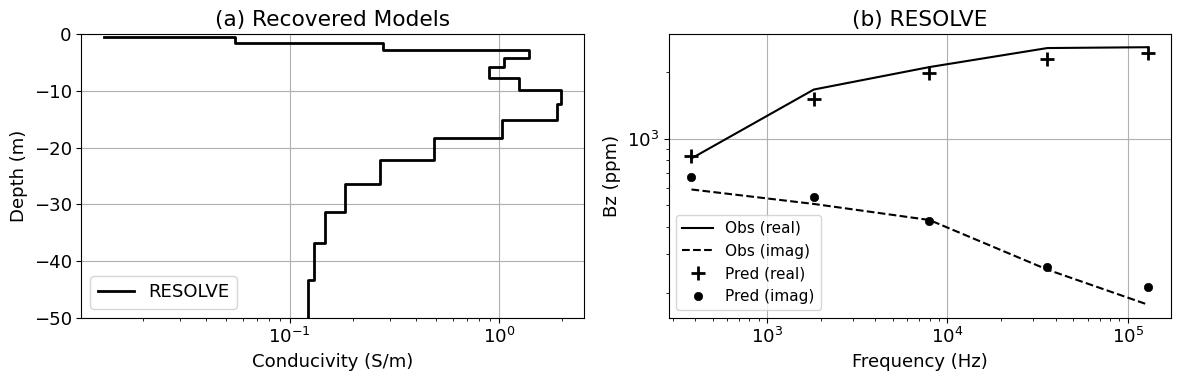

In [39]:
# Plot the figure from the paper
plt.figure(figsize=(12, 4))

fs = 13  # fontsize
matplotlib.rcParams["font.size"] = fs

ax0 = plt.subplot2grid((1, 2), (0, 0))
ax1 = plt.subplot2grid((1, 2), (0, 1))

# Recovered Models
sigma_re = np.repeat(np.exp(res_resolve.model), 2, axis=0)
z = np.repeat(mesh.cell_centers_z[active][1:], 2, axis=0)
z = np.r_[mesh.cell_centers_z[active][0], z, mesh.cell_centers_z[active][-1]]

ax0.semilogx(sigma_re, z, "k", lw=2, label="RESOLVE")
ax0.set_ylim(-50, 0)
# ax0.set_xlim(5e-4, 1e2)
ax0.grid(True)
ax0.set_ylabel("Depth (m)")
ax0.set_xlabel("Conducivity (S/m)")
ax0.legend(loc=3)
ax0.set_title("(a) Recovered Models");

# RESOLVE Data
ax1.loglog(
    frequency_cp, dobs_re.reshape((5, 2))[:, 0] / bp * 1e6, "k-", label="Obs (real)"
)
ax1.loglog(
    frequency_cp,
    dobs_re.reshape((5, 2))[:, 1] / bp * 1e6,
    "k--",
    label="Obs (imag)",
)
ax1.loglog(
    frequency_cp,
    dpred_re.reshape((5, 2))[:, 0] / bp * 1e6,
    "k+",
    ms=10,
    markeredgewidth=2.0,
    label="Pred (real)",
)
ax1.loglog(
    frequency_cp,
    dpred_re.reshape((5, 2))[:, 1] / bp * 1e6,
    "ko",
    ms=6,
    markeredgecolor="k",
    markeredgewidth=0.5,
    label="Pred (imag)",
)
ax1.set_title("(b) RESOLVE")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Bz (ppm)")
ax1.grid(True)
ax1.legend(loc=3, fontsize=11)

plt.tight_layout()

## 4. SkyTEM inversion

### 4.1 Define forward simulation

In [21]:
# Bird height from the surface
b_height_skytem = skytem["src_elevation"][()]
src_height = b_height_skytem[rxind_skytem]
srcLoc = np.array([0.0, 0.0, src_height])

In [22]:
# Radius of the source loop
area = skytem["area"][()]
radius = np.sqrt(area / np.pi)
rxLoc = np.array([[radius, 0.0, src_height]])

In [23]:
# Parameters for current waveform
t0 = skytem["t0"][()]
times = skytem["times"][()]
waveform_skytem = skytem["waveform"][()]
off_time = t0
times_off = times - t0

In [24]:
# Note: we are Using theoretical VTEM waveform,
# but effectively fits SkyTEM waveform
peak_time = 1.0000000e-02

dbdt_z = TDEM.Rx.PointMagneticFluxTimeDerivative(
    locations=rxLoc, times=times_off[:-3] + off_time, orientation="z"
)  # vertical db_dt

receiver_list = [dbdt_z]  # list of receivers
source_list = [
    TDEM.Src.CircularLoop(
        receiver_list,
        location=srcLoc,
        radius=radius,
        orientation="z",
        waveform=TDEM.Src.VTEMWaveform(
            off_time=off_time, peak_time=peak_time, ramp_on_rate=3.0
        ),
    )
]

In [25]:
# solve the problem at these times
timeSteps = [
    (peak_time / 5, 5),
    ((off_time - peak_time) / 5, 5),
    (1e-5, 5),
    (5e-5, 5),
    (1e-4, 10),
    (5e-4, 15),
]
prob = TDEM.Simulation3DElectricField(
    mesh, time_steps=timeSteps, sigmaMap=mapping, solver=SimPEG.Solver
)
survey = TDEM.Survey(source_list)
prob.survey = survey

src = source_list[0]
rx = src.receiver_list[0]
wave = []
for time in prob.times:
    wave.append(src.waveform.eval(time))
wave = np.hstack(wave)

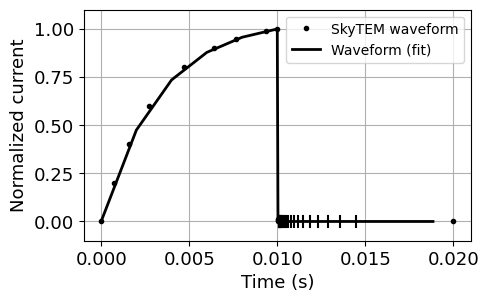

In [26]:
# plot the waveform
fig = plt.figure(figsize=(5, 3))
times_off = times - t0
plt.plot(waveform_skytem[:, 0], waveform_skytem[:, 1], "k.")
plt.plot(prob.times, wave, "k-", lw=2)
plt.legend(("SkyTEM waveform", "Waveform (fit)"), fontsize=10)
for t in rx.times:
    plt.plot(np.ones(2) * t, np.r_[-0.03, 0.03], "k-")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Normalized current");

In [27]:
# Observed data
dobs_sky = skytem["data"][rxind_skytem, :-3] * area

### 4.2 Define objective function

In [28]:
# Uncertainty
relative = 0.12
floor = 7.5e-12
std = abs(dobs_sky) * relative + floor

# Data Misfit
data_sky = SimPEG.data.Data(dobs=-dobs_sky, survey=survey, standard_deviation=std)
dmisfit = SimPEG.data_misfit.L2DataMisfit(simulation=prob, data=data_sky)

# Regularization
reg_lamda_damping = 0.01
reg_lamda_flattening = 0.001
reg_lamda_smoothing = 0.1
reg_damping = cofi.utils.QuadraticReg("damping", (m0.size,), res_resolve.model)
reg_flattening = cofi.utils.QuadraticReg("flattening", (m0.size,), res_resolve.model)
reg_smoothing = cofi.utils.QuadraticReg("smoothing", (m0.size,), res_resolve.model)
reg = reg_lamda_damping * reg_damping + \
        reg_lamda_flattening * reg_flattening + \
        reg_lamda_smoothing * reg_smoothing

In [29]:
def my_objective(model):
    return dmisfit(model) + reg(model)

def my_gradient(model):
    return dmisfit.deriv(model) + reg.gradient(model)

### 4.3 Run inversion with CoFI

In [30]:
problem_skytem = cofi.BaseProblem()
problem_skytem.set_objective(my_objective)
problem_skytem.set_gradient(my_gradient)
problem_skytem.set_initial_model(res_resolve.model)

In [31]:
options_skytem = cofi.InversionOptions()
options_skytem.set_tool("scipy.optimize.minimize")
options_skytem.set_params(method="L-BFGS-B")

In [32]:
inversion_skytem = cofi.Inversion(problem_skytem, options_skytem)
res_skytem = inversion_skytem.run()

### 4.4 Plot both results

In [33]:
dpred_sky = prob.dpred(res_skytem.model)

/tmp/ipykernel_173765/3115304815.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


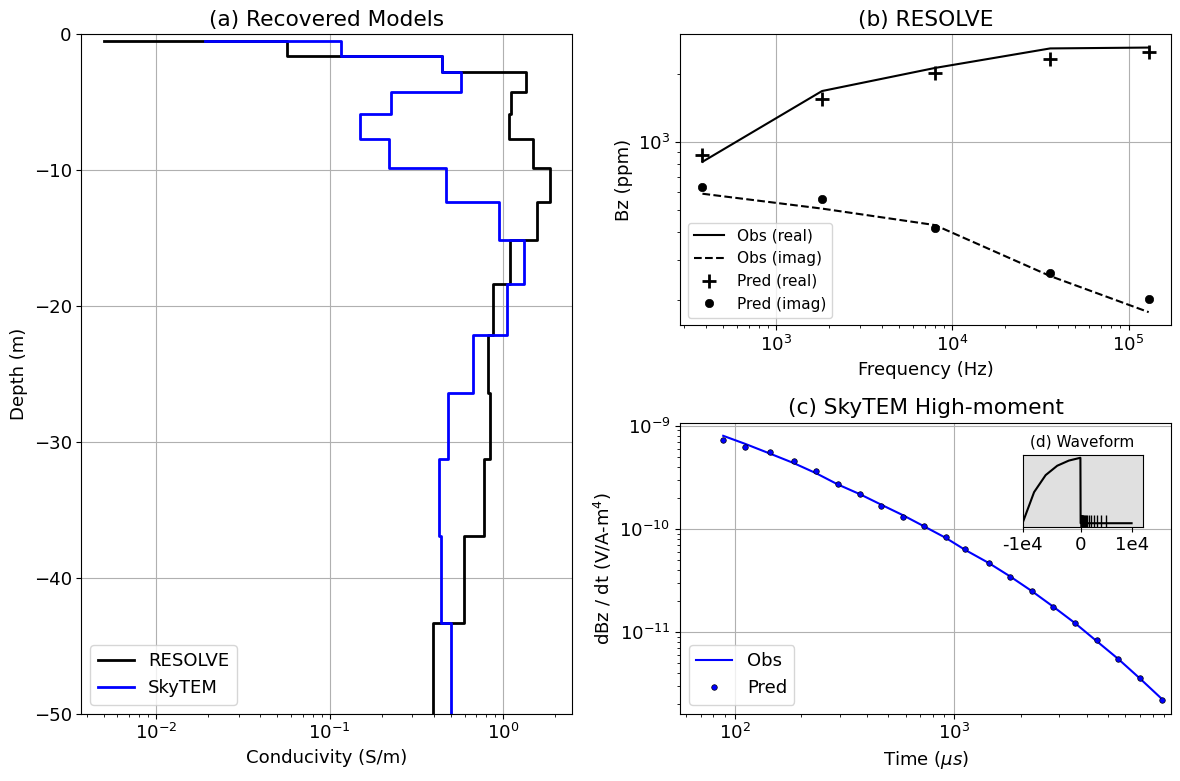

In [34]:
# Plot the figure from the paper
plt.figure(figsize=(12, 8))

fs = 13  # fontsize
matplotlib.rcParams["font.size"] = fs

ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax2 = plt.subplot2grid((2, 2), (1, 1))

# Recovered Models
sigma_re = np.repeat(np.exp(res_resolve.model), 2, axis=0)
sigma_sky = np.repeat(np.exp(res_skytem.model), 2, axis=0)
z = np.repeat(mesh.cell_centers_z[active][1:], 2, axis=0)
z = np.r_[mesh.cell_centers_z[active][0], z, mesh.cell_centers_z[active][-1]]

ax0.semilogx(sigma_re, z, "k", lw=2, label="RESOLVE")
ax0.semilogx(sigma_sky, z, "b", lw=2, label="SkyTEM")
ax0.set_ylim(-50, 0)
# ax0.set_xlim(5e-4, 1e2)
ax0.grid(True)
ax0.set_ylabel("Depth (m)")
ax0.set_xlabel("Conducivity (S/m)")
ax0.legend(loc=3)
ax0.set_title("(a) Recovered Models");

# RESOLVE Data
ax1.loglog(
    frequency_cp, dobs_re.reshape((5, 2))[:, 0] / bp * 1e6, "k-", label="Obs (real)"
)
ax1.loglog(
    frequency_cp,
    dobs_re.reshape((5, 2))[:, 1] / bp * 1e6,
    "k--",
    label="Obs (imag)",
)
ax1.loglog(
    frequency_cp,
    dpred_re.reshape((5, 2))[:, 0] / bp * 1e6,
    "k+",
    ms=10,
    markeredgewidth=2.0,
    label="Pred (real)",
)
ax1.loglog(
    frequency_cp,
    dpred_re.reshape((5, 2))[:, 1] / bp * 1e6,
    "ko",
    ms=6,
    markeredgecolor="k",
    markeredgewidth=0.5,
    label="Pred (imag)",
)
ax1.set_title("(b) RESOLVE")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Bz (ppm)")
ax1.grid(True)
ax1.legend(loc=3, fontsize=11)

# SkyTEM data
ax2.loglog(times_off[3:] * 1e6, dobs_sky / area, "b-", label="Obs")
ax2.loglog(
    times_off[3:] * 1e6,
    -dpred_sky / area,
    "bo",
    ms=4,
    markeredgecolor="k",
    markeredgewidth=0.5,
    label="Pred",
)
ax2.set_xlim(times_off.min() * 1e6 * 1.2, times_off.max() * 1e6 * 1.1)

ax2.set_xlabel(r"Time ($\mu s$)")
ax2.set_ylabel("dBz / dt (V/A-m$^4$)")
ax2.set_title("(c) SkyTEM High-moment")
ax2.grid(True)
ax2.legend(loc=3)

a3 = plt.axes([0.86, 0.33, 0.1, 0.09], facecolor=[0.8, 0.8, 0.8, 0.6])
a3.plot(prob.times * 1e6, wave, "k-")
a3.plot(
    rx.times * 1e6, np.zeros_like(rx.times), "k|", markeredgewidth=1, markersize=12
)
a3.set_xlim([prob.times.min() * 1e6 * 0.75, prob.times.max() * 1e6 * 1.1])
a3.set_title("(d) Waveform", fontsize=11)
a3.set_xticks([prob.times.min() * 1e6, t0 * 1e6, prob.times.max() * 1e6])
a3.set_yticks([])
# a3.set_xticklabels(['0', '2e4'])
a3.set_xticklabels(["-1e4", "0", "1e4"])

plt.tight_layout()

In [35]:
# close files
resolve.close()
skytem.close()

---
## Watermark

In [34]:
watermark_list = ["cofi", "numpy", "scipy", "SimPEG", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.0
numpy 1.23.5
scipy 1.10.1
SimPEG 0.19.0
matplotlib 3.7.1
